In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lmphoton.simulation import current_simulation as sim
import lmtimesim
from lmphoton import OptNetwork
from lmphoton.models import DirectionalCoupler
from lmtimesim.components.Filters.crr_phase_shifter import CRR_PhaseShifter
from tqdm import tqdm

from scipy import constants as const
from scipy import interpolate
import scipy

import pandas as pd

um = 1e-6

In [2]:
no_iterations = 10001

wavelengths = np.linspace(1.308, 1.312, 10000)*um
freqs = const.c / wavelengths

baseline_wavelength = 1310e-9
baseline_frequency = const.c/baseline_wavelength
baseline_wavelength = const.c/baseline_frequency

In [3]:
def get_gain_data_extrapolated(gain_data, freqs_new, baseline_frequency):
      gain_data_extrapolated = np.zeros_like(freqs_new)
      freqs_norm = freqs_new - baseline_frequency
      gain_data_fit = scipy.interpolate.interp1d(gain_data[:,0],gain_data[:,1],kind='cubic')
      for i in range(freqs_norm.shape[0]):
            if np.abs(freqs_norm[i]) <= np.min(gain_data[:,0]):
                  gain_data_extrapolated[i] = gain_data[0,1]
            elif np.abs(freqs_norm[i]) >= np.max(gain_data[:,0]):
                  gain_data_extrapolated[i] = gain_data[-1,1]
            else:
                  gain_data_extrapolated[i] = gain_data_fit(np.abs(freqs_norm[i]))
      gain_data_extrapolated = (10 ** (gain_data_extrapolated/20))
      return gain_data_extrapolated/np.max(gain_data_extrapolated)

TIA output noise:  69.88900757230698 uV


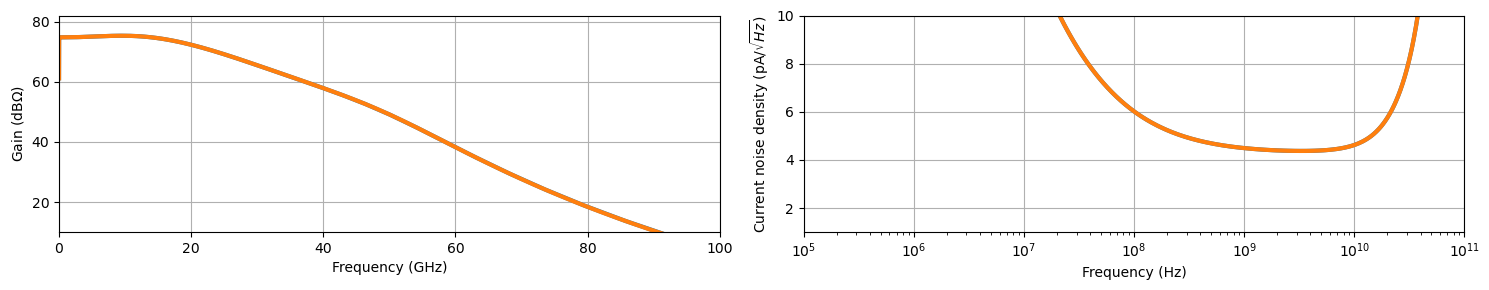

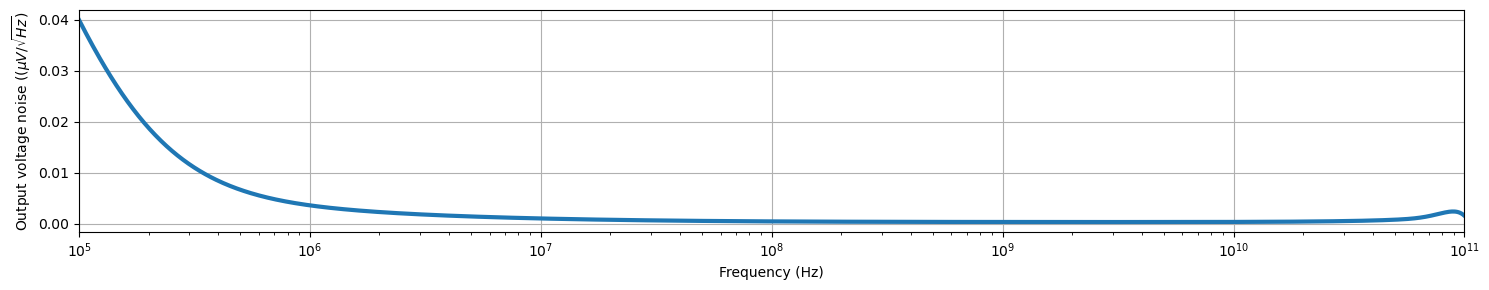

In [4]:
gain_data = pd.read_csv("TIA_gain.csv").to_numpy()
noise_data = pd.read_csv("TIA_currentnoise.csv").to_numpy()
frequency_data = np.logspace(5,11,1001)

gain_data_fit = scipy.interpolate.interp1d(gain_data[:,0],gain_data[:,1],kind='cubic')(frequency_data)
noise_data_fit = scipy.interpolate.interp1d(noise_data[:,0],noise_data[:,1],kind='cubic')(frequency_data)
output_noise_data = gain_data_fit * noise_data_fit

location = lambda f: np.argmin(np.abs(frequency_data - f))

bw_2n = 28e9 * 1.49
freq = bw_2n
freq =30e9
idx_freq = location(freq)

tia_output_noise = np.sqrt(scipy.integrate.trapezoid(output_noise_data[0:idx_freq+1]**2, frequency_data[0:idx_freq+1]))
print("TIA output noise: ", tia_output_noise*1e6, "uV")

plt.figure(figsize=(15,3))
plt.subplot(121)
plt.plot(gain_data[:,0]/1e9,gain_data[:,1], linewidth=3.0)
plt.plot(frequency_data/1e9,gain_data_fit, linewidth=3.0)
plt.xlim(0,1e2)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Gain (dB" + r"$\Omega$)")
plt.grid(True)
plt.ylim(10,82)
plt.subplot(122)
plt.semilogx(noise_data[:,0],noise_data[:,1]*1e12, linewidth=3.0)
plt.semilogx(frequency_data,noise_data_fit*1e12, linewidth=3.0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Current noise density (pA/" + r"$\sqrt{Hz}$)")
plt.grid(True)
plt.xlim(1e5,1e11)
plt.ylim(1,10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plt.semilogx(frequency_data,output_noise_data*1e6, linewidth=3.0)
plt.xlim(1e5,1e11)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Output voltage noise " + r"($(\mu V/\sqrt{Hz}$)")
plt.tight_layout()
plt.grid(True)
plt.show()

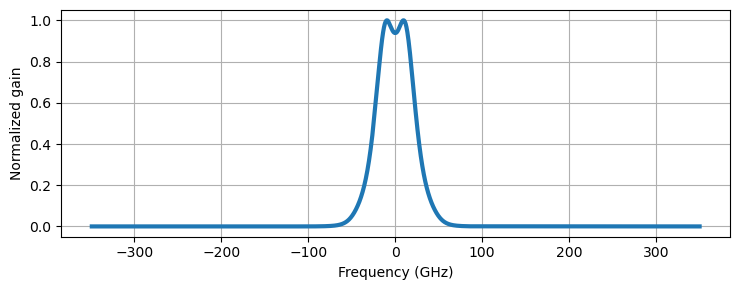

In [5]:
gain_data_extrapolated = get_gain_data_extrapolated(gain_data, freqs, baseline_frequency)
plt.figure(figsize=(7.5,3))
plt.plot((freqs - baseline_frequency)/1e9, gain_data_extrapolated, linewidth=3.0)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Normalized gain")
plt.tight_layout()
plt.grid(True)
plt.show()

In [6]:
class CRR(OptNetwork):
   
    def __init__(
            self,
            ports=('1l', '2r', '3r', '4l'),
            name='CRR',
            dL=0, #Length offset to CRR waveguides
            crr_index=1,
            radius=4.465 * um,
            bus_power_coupling = 0.2809,
            ring_ring_power_coupling = 0.0484,
            phase_shifter_class=CRR_PhaseShifter):
        ## Device physical parameters
        self.name = name
        self.crr_index = crr_index
        self.waveguide_loss_rate = 1.3
        self.radius = radius
        self.lc = 5 * um
        #L_waveguide is the round trip length of the CRR
        self.L_waveguide = 2 * np.pi * self.radius + 2 * self.lc + 2 * dL #dL added to both sides of the ring
        self.external_coupling = bus_power_coupling
        self.internal_coupling = ring_ring_power_coupling

        #Thermo-optic properties
        self._bottom_ring_heater_voltage = 0
        self._top_ring_heater_voltage = 0

        self._rc_filter_bool = False

        self.ps1 = phase_shifter_class(length=self.L_waveguide, loss_rate=self.waveguide_loss_rate)
        self.ps2 = phase_shifter_class(length=self.L_waveguide, loss_rate=self.waveguide_loss_rate)

        self.dc_bus = DirectionalCoupler(splitratio=self.external_coupling)
        self.dc_internal = DirectionalCoupler(splitratio=self.internal_coupling)
        self.dc_drop = DirectionalCoupler(splitratio=self.external_coupling)

        super().__init__(
            ports=ports,
            name=name,
            children={
                f'DC1_CRR_{self.crr_index}': self.dc_bus, #Bus port cavity
                f'PS1_CRR_{self.crr_index}':
                self.ps1, #Phase shifter is a standing for thermal tuner
                f'DC2_CRR_{self.crr_index}': self.dc_internal, #Internal coupler
                f'PS2_CRR_{self.crr_index}': self.ps2,
                f'DC3_CRR_{self.crr_index}': self.dc_drop, # Drop port cavity
            },
            links=[
                (f'DC1_CRR_{self.crr_index}:PORT3', f'PS1_CRR_{self.crr_index}:PORT1'),
                (f'PS1_CRR_{self.crr_index}:PORT2', f'DC2_CRR_{self.crr_index}:PORT1'),
                (f'DC2_CRR_{self.crr_index}:PORT2', f'DC1_CRR_{self.crr_index}:PORT4'),
                (f'DC2_CRR_{self.crr_index}:PORT4', f'PS2_CRR_{self.crr_index}:PORT1'),
                (f'PS2_CRR_{self.crr_index}:PORT2', f'DC3_CRR_{self.crr_index}:PORT1'),
                (f'DC3_CRR_{self.crr_index}:PORT2', f'DC2_CRR_{self.crr_index}:PORT3'),
            ])

    @property
    def bottom_ring_heater_voltage(self):
        return self.ps1.heater_voltage

    @bottom_ring_heater_voltage.setter
    def bottom_ring_heater_voltage(self, new_voltage):
        self.ps1.heater_voltage = new_voltage

    @property
    def top_ring_heater_voltage(self):
        return self.ps2.heater_voltage

    @top_ring_heater_voltage.setter
    def top_ring_heater_voltage(self, new_voltage):
        self.ps2.heater_voltage = new_voltage

    @property
    def bottom_ring_heater_current(self):
        return self.ps1.heater_current

    @property
    def top_ring_heater_current(self):
        return self.ps2.heater_current

    @property
    def rc_filter_bool(self):
        return self._rc_filter_bool

    @rc_filter_bool.setter
    def rc_filter_bool(self, new_rc_filter_bool):
        self._rc_filter_bool = new_rc_filter_bool
        self.ps1.rc_filter_bool = self.rc_filter_bool
        self.ps2.rc_filter_bool = self.rc_filter_bool

    def thru_port_transmission(self):
        return np.abs(self._construct_smatrix()[1, 0])**2

    def drop_port_transmission(self):
        return np.abs(self._construct_smatrix()[3, 0])**2

    def check_children_timesteps(self):
        if (self.ps1.check_children_timesteps()) and (self.ps2.check_children_timesteps()):
            return True
        else:
            return False
        

class CustomCRR(CRR):

    class CustomCRRPhaseShifter(CRR_PhaseShifter):

        def __init__(self,
                     length,
                     loss_rate,
                     ports: tuple[str, str] = ('1l', '2r'),
                     name: str = 'PS'):
            index = 2.45        # Updated from LMPDK
            group_index = 4.276 # Updated from LMPDK
            thermal_time_constant1 = 26e-6
            thermal_time_constant2 = 120e-6
            thermal_weight1 = 0.52
            thermal_weight2 = 0.48
            Rheat0 = 2 * 26.1
            rheat_tc = 0.001626
            waveguide_thermal_resistance = 2 / 3 * 2 * 9834 #Degrees C per Watt
            heater_thermal_resistance = 2 * 9788.8 #Degrees C per Watt
            #2/3 comes from thermal crosstalk model to make sure this model is valid
            

            super().__init__(ports=ports,
                             name=name,
                             length=length,
                             index=index,
                             group_index=group_index,
                             loss_rate=loss_rate,
                             thermal_time_constant1=thermal_time_constant1,
                             thermal_time_constant2=thermal_time_constant2,
                             thermal_weight1=thermal_weight1,
                             thermal_weight2=thermal_weight2,
                             Rheat0=Rheat0,
                             rheat_tc=rheat_tc,
                             waveguide_thermal_resistance=waveguide_thermal_resistance,
                             heater_thermal_resistance=heater_thermal_resistance)

    #A CRR for razorcrest designed for operation on 1800GHz FSR
    def __init__(
            self,
            ports=('1l', '2r', '3r', '4l'),
            name='Custom_CRR',
            dL=0, #Length offset to CRR waveguides
            bus_power_coupling = 0.2809,
            ring_ring_power_coupling = 0.0484,
            crr_index=1):
        super().__init__(ports=ports,
                         name=name,
                         dL=dL,
                         crr_index=crr_index,
                         radius=4.465 * um,
                         bus_power_coupling = bus_power_coupling,
                         ring_ring_power_coupling = ring_ring_power_coupling,
                         phase_shifter_class=CustomCRR.CustomCRRPhaseShifter)

In [7]:
def find_crossings(x, y, target_value):
          # Find indices where the curve crosses the target value
    indices = np.where(np.diff(np.sign(y - target_value)))[0]
    
    # Initialize list to store crossing points
    crossing_points = []

    for idx in indices:
        # Points around the crossing
        x1, x2 = x[idx], x[idx + 1]
        y1, y2 = y[idx], y[idx + 1]
        
        # Linear interpolation
        if y2 != y1:  # Avoid division by zero
            x_cross = x1 + (target_value - y1) * (x2 - x1) / (y2 - y1)
            crossing_points.append(x_cross)
        else:
            # If y1 == y2 and it's exactly the target value, both points are crossings
            if y1 == target_value:
                crossing_points.extend([x1, x2])
    
    return np.array(crossing_points)

# Create a 56G NRZ spectrum
def generate_56G_spectrum(center_wavelength,wavelength_sweep):
    frequency_sweep = const.c/wavelength_sweep
    center_frequency = const.c/center_wavelength
    diff_freq = center_frequency - frequency_sweep
    Tb = 1/(56e9)
    tp = np.array([0.5 * Tb * (np.sin(np.pi*f*Tb)/(np.pi*f*Tb))**2 for f in diff_freq])

    tp /= np.max(tp)

    return tp

def raised_cosine(center_wavelength,wavelength_sweep,T=1/(56e9),beta=0.28):
    frequency_sweep = const.c/wavelength_sweep
    center_frequency = const.c/center_wavelength
    diff_freq = center_frequency - frequency_sweep
    returnable = []
    for f in diff_freq:
        if np.abs(f) < (1-beta)/(2*T):
            returnable.append(1)
        elif ((1-beta)/(2*T) < np.abs(f)) and (np.abs(f) < (1+beta)/(2*T)):
            returnable.append(0.5 * (1 + np.cos(np.pi *T /beta * (np.abs(f) - (1-beta)/(2*T)))))
        else:
            returnable.append(0)
    return np.array(returnable)

/var/folders/gl/2rnst3qn1ybbrqznnrfypxkw0000gn/T/ipykernel_24370/4126160137.py:68: RuntimeWarning: divide by zero encountered in log10
  plt.plot((freqs - baseline_frequency)/1e9,10*np.log10(tp_og_170GHz), linewidth=3.0, linestyle = '--', color="black", label = "56Gbps at 170 (GHz) offset")
/var/folders/gl/2rnst3qn1ybbrqznnrfypxkw0000gn/T/ipykernel_24370/4126160137.py:69: RuntimeWarning: divide by zero encountered in log10
  plt.plot((freqs - baseline_frequency)/1e9,10*np.log10(tp_og_230GHz), linewidth=3.0, linestyle = ':', color="black", label = "56Gbps at 230 (GHz) offset")


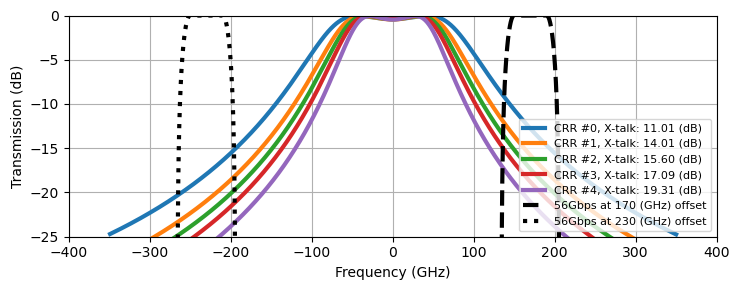

In [8]:
#Pairs of coupling rates targetting different design points
coupling_rate_pairs = np.array([
    (0.2809,0.0484), #index=0, for ~142GHz 1dB passband
    (0.241,0.035),   #index=1, for ~120GHz 1dB passband
    (0.225,0.0291),  #index=2, for ~110GHz 1dB passband
    (0.21,0.0245),   #index=3, for ~100GHz 1dB passband
    (0.185,0.0195),  #index=4, for ~90GHz 1dB passband
])
    
drop_port_storage = np.zeros((wavelengths.shape[0], coupling_rate_pairs.shape[0]))
thru_port_storage = np.zeros((wavelengths.shape[0], coupling_rate_pairs.shape[0]))

baseline_frequency_plus_170GHz = baseline_frequency + 170e9
baseline_wavelength_plus_170GHz = const.c/baseline_frequency_plus_170GHz

baseline_frequency_minus_230GHz = baseline_frequency - 230e9
baseline_wavelength_minus_230GHz = const.c/baseline_frequency_minus_230GHz

tp_og = raised_cosine(baseline_wavelength,wavelengths)
tp_og_170GHz = raised_cosine(baseline_wavelength_plus_170GHz,wavelengths)
tp_og_230GHz = raised_cosine(baseline_wavelength_minus_230GHz,wavelengths)

tia_response = get_gain_data_extrapolated(gain_data, freqs, baseline_frequency)
tia_response_170GHz = get_gain_data_extrapolated(gain_data, freqs, baseline_frequency_plus_170GHz)
tia_response_230GHz = get_gain_data_extrapolated(gain_data, freqs, baseline_frequency_minus_230GHz)

tp = tia_response * tp_og
tp_170GHz = tia_response_170GHz * tp_og_170GHz
tp_230GHz = tia_response_230GHz * tp_og_230GHz

plt.figure(figsize=(7.5, 3))
for crr_index, crr_coupling_rates in enumerate(coupling_rate_pairs):
    crr = CustomCRR(
        bus_power_coupling = crr_coupling_rates[0],
        ring_ring_power_coupling = crr_coupling_rates[1],
        crr_index=crr_index
    )

    for i in range(10):
        crr.bottom_ring_heater_voltage = 0.7130930930930931 #Voltage found below to park centered at 1310nm
        crr.top_ring_heater_voltage = 0.7130930930930931
        crr.rc_filter_bool = False
        crr.drop_port_transmission()

    
    for wavelength_index, wavelength in enumerate(wavelengths):
        sim().wavelength = wavelength
        crr._wavelength = wavelength
        drop_port_storage[wavelength_index, crr_index] = crr.drop_port_transmission()
        thru_port_storage[wavelength_index, crr_index] = crr.thru_port_transmission()


    #From the response, what is the ripple? What is the 1dB bandwidth?
    sim().wavelength = 1310e-9
    crr._wavelength  = 1310e-9
    
    power_intersection_1dB_down_from_max = np.max(drop_port_storage[:, crr_index])*10**(-1/10)
    crossing_points = find_crossings(wavelengths,drop_port_storage[:, crr_index],power_intersection_1dB_down_from_max)
    
    x_talk_dB = 10*np.log10((tp @ drop_port_storage[:, crr_index]) / ((tp_170GHz + tp_230GHz) @ drop_port_storage[:, crr_index]))
    plt.plot((freqs - baseline_frequency)/1e9,10*np.log10(drop_port_storage[:, crr_index]), linewidth=3.0, label = f"CRR #{crr_index}, X-talk: {x_talk_dB:0.2f} (dB)")
    plt.xlim(-400, 400)
    plt.ylim(-25,0)
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("Transmission (dB)")
    plt.grid(True)

plt.plot((freqs - baseline_frequency)/1e9,10*np.log10(tp_og_170GHz), linewidth=3.0, linestyle = '--', color="black", label = "56Gbps at 170 (GHz) offset")
plt.plot((freqs - baseline_frequency)/1e9,10*np.log10(tp_og_230GHz), linewidth=3.0, linestyle = ':', color="black", label = "56Gbps at 230 (GHz) offset")
plt.legend(loc=4, fontsize=8)
plt.tight_layout()
plt.show()

x_talk_dB = 10*np.log10((tp @ drop_port_storage) / (tp_170GHz @ drop_port_storage))

In [9]:
#Create a monte-carlo sim to run
def monte_carlo_sim(fsr_diff = 200e9, freq_offset_error_sigma = 10e9, drop_port=drop_port_storage[:,0]):
    baseline_wavelength = 1310e-9
    baseline_frequency = const.c/baseline_wavelength
    baseline_freq_with_variation = np.random.normal(baseline_frequency,scale=(1e9)/4) #Factor of 4 because of 4-sigma
    baseline_freq_aggressor_with_positive_variation = np.random.normal(baseline_frequency+fsr_diff,scale=freq_offset_error_sigma)
    baseline_freq_aggressor_with_negative_variation = np.random.normal(baseline_frequency-(400e9-fsr_diff),scale=freq_offset_error_sigma)
    baseline_wavelength_with_variation = const.c/baseline_freq_with_variation
    baseline_wavelength_aggressor_with_positive_variation = const.c/baseline_freq_aggressor_with_positive_variation
    baseline_wavelength_aggressor_with_negative_variation = const.c/baseline_freq_aggressor_with_negative_variation

    tp_main = raised_cosine(baseline_wavelength_with_variation,wavelengths)
    tp_positive_aggressor = raised_cosine(baseline_wavelength_aggressor_with_positive_variation,wavelengths)
    tp_negative_aggressor = raised_cosine(baseline_wavelength_aggressor_with_negative_variation,wavelengths)

    tia_response = get_gain_data_extrapolated(gain_data, freqs, baseline_frequency)
    tia_response_positive_variation = get_gain_data_extrapolated(gain_data, freqs, baseline_freq_aggressor_with_positive_variation)
    tia_response_negative_variation = get_gain_data_extrapolated(gain_data, freqs, baseline_freq_aggressor_with_negative_variation)

    tp_after_tia = tia_response * tp_main
    tp_after_tia_positive_variation = tia_response_positive_variation * tp_positive_aggressor
    tp_after_tia_negative_variation = tia_response_negative_variation * tp_negative_aggressor

    # Measure the sum of the spectrum and compare their ratios
    delta_frequency = baseline_wavelength_aggressor_with_positive_variation - baseline_freq_with_variation
    x_talk_dB = 10*np.log10(np.sum(tp_after_tia*drop_port)/np.sum((tp_after_tia_positive_variation + tp_after_tia_negative_variation)*drop_port))
    return delta_frequency, x_talk_dB

In [10]:
simulation_cases = np.array([
      (190e9, 8e9),
      (190e9, 6e9),
      (190e9, 3e9),
      (200e9, 8e9),
      (200e9, 0.25e9)
])

monte_carlo_freq_storage = np.zeros((drop_port_storage.shape[0], no_iterations, simulation_cases.shape[0]))
monte_carlo_ratio_storage = np.zeros((drop_port_storage.shape[0], no_iterations, simulation_cases.shape[0]))

for crr_index, crr_coupling_rates in enumerate(coupling_rate_pairs):
      for simulation_case_index, simulation_case in enumerate(simulation_cases):
            for idd_iter in tqdm(range(no_iterations), desc=f"CRR index {crr_index} Simulation case {simulation_case_index} with fsr_diff = {simulation_case[0]/1e9} GHz and freq_offset_error_sigma = {simulation_case[1]/1e9} GHz"):
                  monte_carlo_freq_storage[crr_index, idd_iter, simulation_case_index], monte_carlo_ratio_storage[crr_index, idd_iter, simulation_case_index] = monte_carlo_sim(fsr_diff=simulation_case[0], freq_offset_error_sigma=simulation_case[1], drop_port=drop_port_storage[:,crr_index])

CRR index 0 Simulation case 0 with fsr_diff = 190.0 GHz and freq_offset_error_sigma = 8.0 GHz: 100%|██████████| 10001/10001 [33:05<00:00,  5.04it/s]
CRR index 0 Simulation case 1 with fsr_diff = 190.0 GHz and freq_offset_error_sigma = 6.0 GHz: 100%|██████████| 10001/10001 [33:00<00:00,  5.05it/s]
CRR index 0 Simulation case 2 with fsr_diff = 190.0 GHz and freq_offset_error_sigma = 3.0 GHz: 100%|██████████| 10001/10001 [32:59<00:00,  5.05it/s]
CRR index 0 Simulation case 3 with fsr_diff = 200.0 GHz and freq_offset_error_sigma = 8.0 GHz: 100%|██████████| 10001/10001 [33:00<00:00,  5.05it/s]
CRR index 0 Simulation case 4 with fsr_diff = 200.0 GHz and freq_offset_error_sigma = 0.25 GHz: 100%|██████████| 10001/10001 [33:00<00:00,  5.05it/s]
CRR index 1 Simulation case 0 with fsr_diff = 190.0 GHz and freq_offset_error_sigma = 8.0 GHz: 100%|██████████| 10001/10001 [33:01<00:00,  5.05it/s]
CRR index 1 Simulation case 1 with fsr_diff = 190.0 GHz and freq_offset_error_sigma = 6.0 GHz: 100%|█████

In [11]:
ecdf_interest = np.array([0.6827, 0.954, 0.997, 0.9995])
monte_carlo_ecdf_storage = np.zeros((2,drop_port_storage.shape[1],simulation_cases.shape[0], 4))

for simulation_case_index, simulation_case in enumerate(simulation_cases):
      for crr_index in range(drop_port_storage.shape[1]):   
            for ecdf_index, ecdf_value in enumerate(ecdf_interest):
                  monte_carlo_ecdf_storage[0,crr_index,simulation_case_index,ecdf_index] = np.percentile(monte_carlo_freq_storage[:,crr_index,simulation_case_index],100*(1-ecdf_value))
                  monte_carlo_ecdf_storage[1,crr_index,simulation_case_index,ecdf_index] = np.percentile(monte_carlo_ratio_storage[:,crr_index,simulation_case_index],100*(1-ecdf_value))
monte_carlo_ecdf_storage.shape

(2, 5, 5, 4)

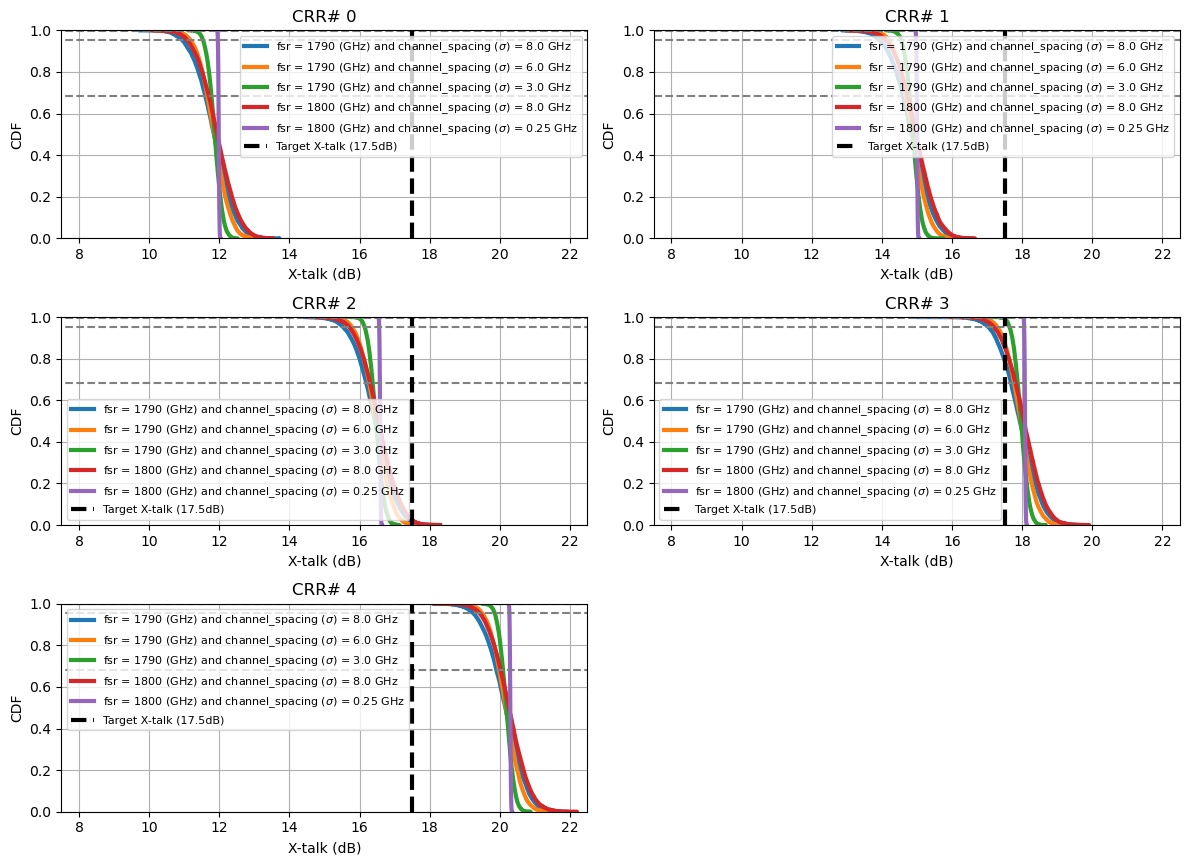

In [12]:
figsize_x = 12
figsize_y = 3.5*monte_carlo_ecdf_storage.shape[1]/2
plt.figure(figsize=(figsize_x, figsize_y))
for crr_index in range(monte_carlo_ecdf_storage.shape[1]):
      plt.subplot(int(np.ceil(monte_carlo_ecdf_storage.shape[1]/2)),2,crr_index+1)
      for simulation_case_index in range(monte_carlo_ecdf_storage.shape[2]):
            plt.ecdf(monte_carlo_ratio_storage[crr_index, :,simulation_case_index], linewidth=3.0, complementary=True, label=f"fsr = {simulation_cases[simulation_case_index, 0]/1e9 + 1600:0.0f} (GHz) and channel_spacing ("+r"$\sigma$"+f") = {simulation_cases[simulation_case_index,1]/1e9} GHz")
            plt.xlabel("X-talk (dB)")
            plt.ylabel("CDF")
            plt.title(f"CRR# {crr_index}")
            plt.grid(True)
      
      plt.hlines(0.9995,xmin=5,xmax=25,color='grey',linestyle='--')
      plt.hlines(0.997,xmin=5,xmax=25,color='grey',linestyle='--')
      plt.hlines(0.954,xmin=5,xmax=25,color='grey',linestyle='--')
      plt.hlines(0.6827,xmin=5,xmax=25,color='grey',linestyle='--')
      plt.vlines(17.5, ymin=0, ymax=1, color='black',linewidth = 3.0, linestyle='--', label = "Target X-talk (17.5dB)")
      plt.xlim([7.5,22.5])
      plt.legend(fontsize=8)
plt.tight_layout()

In [13]:
np.savez_compressed("monte_carlo.npz", monte_carlo_ecdf_storage=monte_carlo_ecdf_storage, monte_carlo_ratio_storage=monte_carlo_ratio_storage, monte_carlo_freq_storage=monte_carlo_freq_storage, coupling_rate_pairs=coupling_rate_pairs, simulation_cases=simulation_cases)